## Ejemplo de juguete OMP

In [113]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

### Definir diccionario

In [ ]:
### Dictionary
def dictionary_WPT(samples=1024, max_level=6, mother_wavelet='db4'):
    import pywt
    from sklearn.preprocessing import normalize
    # Base signal
    signal = np.zeros(samples)

    # Base tree
    wp_original = pywt.WaveletPacket(data=signal, wavelet=mother_wavelet, mode='periodization', maxlevel=max_level)

    dictionary = []
    dictionary_columns = []

    for level in range(1, max_level + 1):
        nodes = wp_original.get_level(level, order='natural')
        #print(f"Nivel {level}:")
        for node in nodes:
            #print(f"  Nodo: {node.path}, longitud: {len(node.data)}")
            dictionary_columns.append([node.path, len(node.data)])
            for i in range(len(node.data)):
                # New Tree
                wp_temp = pywt.WaveletPacket(data=None, wavelet=mother_wavelet, mode='periodization', maxlevel=max_level)

                # Zero Coefficients
                for other_node in wp_original.get_level(level, order='natural'):
                    wp_temp[other_node.path] = np.zeros_like(other_node.data)

                # One coefficient
                impulse = np.zeros_like(node.data)
                impulse[i] = 1
                wp_temp[node.path] = impulse

                # Rebuild signal (atom)
                signal_rec = wp_temp.reconstruct(update=False)

                # Normalize L2
                norm = np.linalg.norm(signal_rec)
                if norm > 0:
                    signal_rec /= norm

                dictionary.append(signal_rec)

    dictionary = np.array(dictionary)
    dictionary = normalize(dictionary, axis=1) 
    return dictionary_columns, dictionary

In [125]:
## Create Dictionary
coef_dictionary, D = dictionary_WPT()
atom, samples = D.shape
print('Shape dictionary', D.shape)

Shape dictionary (6144, 1024)


### Crear señales sintéticas

[47, 246, 894, 965, 1128, 1618, 3037, 3390, 3946, 5310, 5498, 5527]


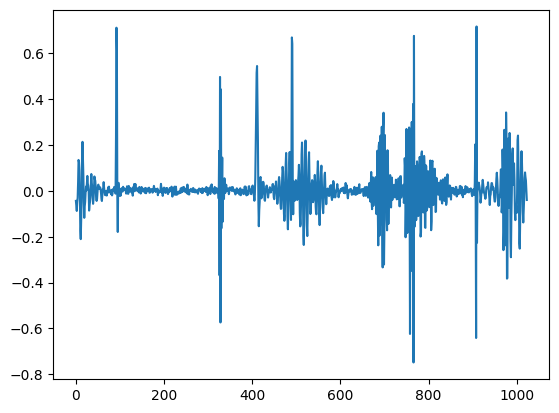

(1, 1024)


In [138]:
def signals_class(num_atoms, dictionary, num_signals):
    atom, samples = D.shape
    atomos = []
    for i in range(num_atoms):
        atomos.append(np.random.randint(atom))
    
    signal = np.zeros((samples))
    for atomo in atomos:
        signal+=dictionary[atomo]
    
    print(sorted(atomos))
    ## Señales fijas
    t = np.linspace(0, 1, samples)

    signals = []
    for i in range(num_signals):
        amp1 = np.random.uniform(0.1, 1.0)           # amplitud entre 0.1 y 1.0
        freq1 = np.random.uniform(1, 20)             # frecuencia entre 1 y 20 Hz
        s1 = amp1 * np.sin(2 * np.pi * freq1 * t)   
        
        amp2 = np.random.uniform(0.1, 1.0)
        freq2 = np.random.uniform(20, 100)           # frecuencia entre 20 y 100 Hz
        s2 = amp2 * np.cos(2 * np.pi * freq2 * t)
        
        ruido = np.random.randn(samples)
        
        signals.append(signal + 0.01*ruido)# + s1 + s2 + ruido)
 
    return np.array(signals)


data = signals_class(12,D,1)

plt.figure()
plt.plot(data[0])
plt.show()

print(data.shape)



### Penalidad

In [129]:
### Fisher Score
def fisher_score(Z, y):
    """
    Z: (N x K) matrix of projections or features
    y: (N,) class labels
    Returns:
        (K,) Fisher score for each atom
    """
    classes = np.unique(y)
    mean_overall = np.mean(Z, axis=0)
    num = np.zeros(Z.shape[1])
    den = np.zeros(Z.shape[1])

    for c in classes:
        Zc = Z[y == c]
        mean_c = np.mean(Zc, axis=0)
        num += Zc.shape[0] * (mean_c - mean_overall)**2
        den += np.sum((Zc - mean_c)**2, axis=0)

    score = np.where(den != 0, num / den, 0)
    return score


### Mutual Information
def Mutual_information(Z, y):
    """
    Z: (N x K) matrix of projections or features
    y: (N,) class labels
    Returns:
        (K,) Mutual information
    """
    mi_scores = mutual_info_classif(Z, y, discrete_features=False, n_neighbors=5, random_state=42)
    return mi_scores

### D-OMP

In [ ]:
### Discriminative OMP
def d_omp(x, D, fisher_scores, T, lamb=1.0):
    """
    x: signal to represent (n,)
    D: dictionary (n x K)
    fisher_scores: (K,) array
    T: sparsity level
    lamb: Fisher score weight
    Returns:
        alpha: sparse coefficient vector (K,)
    """
    n, K = D.shape
    r = x.copy()
    support = []
    alpha = np.zeros(K)

    for _ in range(T):
        projections = D.T @ r  # (K,)
        scores = np.abs(projections) + lamb * fisher_scores
        scores[support] = -np.inf  # avoid reselection
        j_star = np.argmax(scores)
        support.append(j_star)
        D_sub = D[:, support]
        alpha_sub = np.linalg.pinv(D_sub) @ x
        r = x - D_sub @ alpha_sub

    alpha[support] = alpha_sub
    return alpha

### Test

In [139]:
clase_1 = signals_class(120, D, 40)
y_1 = np.zeros((40))
clase_2 = signals_class(120, D, 40)
y_2 = np.ones((40))

X = np.concatenate((clase_1, clase_2))
y = np.concatenate((y_1, y_2))

print(X.shape, y.shape)


[42, 49, 95, 155, 211, 221, 227, 297, 349, 379, 398, 443, 468, 485, 675, 745, 796, 924, 1040, 1109, 1109, 1132, 1145, 1183, 1226, 1284, 1408, 1453, 1614, 1681, 1707, 1709, 1729, 1825, 1861, 1948, 1951, 2098, 2151, 2170, 2181, 2246, 2383, 2420, 2441, 2647, 2725, 2783, 2785, 2844, 2847, 2875, 2892, 2900, 2908, 2967, 3027, 3029, 3034, 3095, 3151, 3172, 3173, 3195, 3235, 3283, 3290, 3428, 3435, 3450, 3494, 3516, 3601, 3617, 3651, 3664, 3713, 3741, 3791, 3886, 3919, 3931, 3935, 3975, 3989, 4061, 4104, 4141, 4287, 4330, 4415, 4429, 4430, 4473, 4512, 4517, 4566, 4571, 4591, 4627, 4654, 4829, 4887, 4910, 4925, 5011, 5128, 5191, 5215, 5231, 5679, 5740, 5768, 5810, 5906, 6013, 6068, 6092, 6095, 6126]
[26, 84, 164, 170, 175, 240, 349, 484, 535, 556, 568, 648, 652, 669, 745, 759, 769, 813, 824, 1015, 1116, 1211, 1212, 1222, 1260, 1316, 1317, 1442, 1521, 1607, 1663, 1714, 1718, 1750, 1914, 1959, 1973, 2009, 2060, 2104, 2227, 2313, 2352, 2476, 2543, 2604, 2775, 2801, 2894, 2921, 2929, 2976, 3041, 31

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('X_train size:',X_train.shape,'X_test size:',X_test.shape,'y_train size:',len(y_test),'y_test size:',len(y_train))

    
# Train Proyections
Z = X_train @ D.T

# Weighing
#scores = fisher_score(Z, y_train)
scores = Mutual_information(Z, y_train)

# Discrminant weight and sparsity
T = 5      # nivel de dispersión
lamb = 1  # peso de discriminación

# D-OMP train
alpha_train = []
for x in X_train:
    alpha = d_omp(x, D.T, scores, T, lamb)
    alpha_train.append(alpha)
alpha_train = np.array(alpha_train)

# Divide per class
alpha_c0 = alpha_train[y_train == 0]
alpha_c1 = alpha_train[y_train == 1]

# Obtener índices de los átomos activados (coeficientes distintos de cero)
activados_c0 = np.where((alpha_c0 != 0).any(axis=0))[0]
activados_c1 = np.where((alpha_c1 != 0).any(axis=0))[0]

print(f"Átomos activados en clase 0 ({len(activados_c0)}):\n{activados_c0}")
print(f"Átomos activados en clase 1 ({len(activados_c1)}):\n{activados_c1}")


# Activations per atom
activaciones_c0 = (alpha_c0 != 0).astype(int).sum(axis=0)
activaciones_c1 = (alpha_c1 != 0).astype(int).sum(axis=0)

solo_c0 = np.setdiff1d(activados_c0, activados_c1)
solo_c1 = np.setdiff1d(activados_c1, activados_c0)
compartidos = np.intersect1d(activados_c0, activados_c1)

print(f"Átomos exclusivos de clase 0 ({len(solo_c0)}):\n{solo_c0}")
print(f"Átomos exclusivos de clase 1 ({len(solo_c1)}):\n{solo_c1}")
print(f"Átomos compartidos por ambas clases ({len(compartidos)}):\n{compartidos}")


X_train size: (64, 1024) X_test size: (16, 1024) y_train size: 16 y_test size: 64
Átomos activados en clase 0 (6):
[1109 1453 1729 2647 5128 5231]
Átomos activados en clase 1 (5):
[ 652  759 3120 3329 4827]
Átomos exclusivos de clase 0 (6):
[1109 1453 1729 2647 5128 5231]
Átomos exclusivos de clase 1 (5):
[ 652  759 3120 3329 4827]
Átomos compartidos por ambas clases (0):
[]
